Trying to make a FCN to predict dihedral angles. The data is from https://github.com/aqlaboratory/proteinnet casp7, text based, using only a subset of the data due to lack of computational resources. Data was preprocessed in https://github.com/githubz0r/random/blob/master/protein_fcn_preproc.ipynb 

In [1]:
import numpy as np
import torch
import imp
import re
import matplotlib.pyplot as plt
import pickle
import PeptideBuilder

Helper function to get the angles from sin and cos using atan2.

In [2]:
def back_to_angle(sin_cos_array, n_angles=3):
    angles = []
    for i in range(n_angles):
        angles_i = np.arctan2(sin_cos_array[:, i, :], sin_cos_array[:, n_angles+i, :])
        # remember that we input sin first due to atan2 definition
        angles_i = angles_i[:, np.newaxis, :]
        angles.append(angles_i)
    angles_arr = np.concatenate(angles, 1)
    return(angles_arr)
aa_id_dict = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7,
              'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14, 
              'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19}
pos_aa_dict = {j:i for i,j in aa_id_dict.items()}

Load files.

In [3]:
train_file = open('protein_fcn_data_test/train_data_proc', 'rb')
train_data = pickle.load(train_file)
train_file.close()

In [4]:
val_file = open('protein_fcn_data_test/val_data_proc', 'rb')
val_data = pickle.load(val_file)
val_file.close()

In [5]:
train_seqs = train_data['train_seqs']
train_coords = train_data['train_coords']
train_angles_sin_cos = train_data['train_angles_sin_cos']
train_angles = [back_to_angle(i.numpy()) for i in train_angles_sin_cos]
train_ids_remain = train_data['train_ids_after_filt']

In [6]:
val_seqs = val_data['val_seqs']
val_coords = val_data['val_coords']
val_angles_sin_cos = val_data['val_angles_sin_cos']
val_angles = [back_to_angle(i.numpy()) for i in val_angles_sin_cos]
val_ids_remain = val_data['val_ids_after_filt']

Quickly check how many proteins there are.

In [7]:
print(len(train_seqs))
print(len(val_seqs))

7964
184


We write a dataset class for the torch DataLoader. Since we only pad the minibatches (instead of everything in one tensor), we also need a custom collate function to deal with this. 

In [8]:
from torch.utils.data import Dataset
class proteindataset(torch.utils.data.Dataset):
    def __init__(self, seqs, angles):
        self.sequences = seqs
        self.angles = angles

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return [self.sequences[idx], self.angles[idx]]

def protein_collate(batch):
    seqs = [item[0] for item in batch]
    angles = [item[1] for item in batch]
    max_len = max([x.shape[2] for x in seqs])
    for i in range(len(batch)):
        curr_len = seqs[i].shape[2]
        seq_padded = np.pad(seqs[i], ((0,0 ), (0,0), (0,max_len-curr_len)), constant_values = 0)
        angles_padded = np.pad(angles[i], ((0,0 ), (0,0), (0,max_len-curr_len)), constant_values = 0)
        seqs[i] = torch.tensor(seq_padded)
        angles[i] = torch.tensor(angles_padded)
    seq_tensor = torch.cat(seqs, 0)
    angle_tensor = torch.cat(angles, 0)
    return([seq_tensor, angle_tensor])
    

In [9]:
train_dataset = proteindataset(train_seqs, train_angles_sin_cos)
val_dataset = proteindataset(val_seqs, val_angles_sin_cos)

In [40]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                          shuffle=True, num_workers=2, collate_fn=protein_collate)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=100,
                                         shuffle=False, num_workers=2, collate_fn=protein_collate)
#testloader = torch.utils.data.DataLoader(test_dataset, batch_size=100, # we don't need testing yet
                                         #shuffle=False, num_workers=2)

Define and run a FCN with mean squared error as loss function. Angles are transformed to sin/cos and will be backtransformed with arctan 2 after training
<br>
First half of the network does convolution and the second half does up-convolution. It also has some skip connections like the U-NET architecture (but simpler).
<br>
<br>
The proteins are encoded as $N*C*L$ where $C$ = 20 (number of amino acids) and $L$ = length.

In [41]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

kd2 = 3
pad2 = int((kd2-1)/2)
kd3 = 5
pad3 = int((kd3-1)/2)
kd4 = 7
pad4 = int((kd4-1)/2)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = nn.Conv1d(20, 20, kernel_size=1)
        self.conv0_bn = torch.nn.BatchNorm1d(20)
        self.conv1 = nn.Conv1d(20, 15, kernel_size=kd2, padding=pad2) # down
        self.conv1_bn = torch.nn.BatchNorm1d(15)
        self.conv2 = nn.Conv1d(15, 30, kernel_size=kd3, padding=pad3) # down 
        self.conv2_bn = torch.nn.BatchNorm1d(30)
        self.conv3 = nn.Conv1d(30, 24, kernel_size=kd4, padding=pad4) # down
        self.conv3_bn = torch.nn.BatchNorm1d(24)
        self.conv4 = nn.Conv1d(24, 24, kernel_size=1)
        self.conv4_bn = torch.nn.BatchNorm1d(24)
        
        self.deconv1 = nn.ConvTranspose1d(in_channels=24, out_channels=30, kernel_size=kd4, padding=pad4) # up
        self.deconv1_bn = torch.nn.BatchNorm1d(30)
        self.conv5 = nn.Conv1d(30, 30, 1)
        self.conv5_bn = torch.nn.BatchNorm1d(30)
        
        self.deconv2 = nn.ConvTranspose1d(in_channels=60, out_channels=15, kernel_size=kd3, padding=pad3) # up
        self.deconv2_bn = torch.nn.BatchNorm1d(15)
        self.conv6 = nn.Conv1d(15, 15, 1)
        self.conv6_bn = torch.nn.BatchNorm1d(15)
        
        self.deconv3 = nn.ConvTranspose1d(in_channels=30, out_channels=15, kernel_size=kd2-1, padding=pad2) # up
        self.deconv3_bn = torch.nn.BatchNorm1d(15)
        self.conv7 = nn.Conv1d(15, 6, (1))
        self.conv7_bn = torch.nn.BatchNorm1d(6)
        self.conv8 = nn.Conv1d(6, 6, 1)
        self.conv8_bn = torch.nn.BatchNorm1d(6)
        self.conv9 = nn.Conv1d(6, 6, 1)

    def forward(self, x):
        conv0_out = F.relu(self.conv0_bn(self.conv0(x)))
        conv1_out = F.relu(self.conv1_bn(self.conv1(conv0_out)))
        conv2_out = F.relu(self.conv2_bn(self.conv2(conv1_out)))
        conv3_out = F.relu(self.conv3_bn(self.conv3(conv2_out)))
        conv4_out = F.relu(self.conv4_bn(self.conv4(conv3_out)))

        deconv1_out = F.relu(self.deconv1_bn(self.deconv1(conv4_out)))
        conv5_out = F.relu(self.conv5_bn(self.conv5(deconv1_out)))
        
        deconv2_input = torch.cat((conv2_out, deconv1_out), 1)  
        deconv2_out = F.relu(self.deconv2_bn(self.deconv2(deconv2_input)))
        conv6_out = F.relu(self.conv6_bn(self.conv6(deconv2_out)))
        
        deconv3_input = torch.cat((conv1_out, deconv2_out), 1)
        deconv3_out = F.relu(self.deconv3_bn(self.deconv3(deconv3_input)))
        conv7_out = F.relu(self.conv7_bn(self.conv7(deconv3_out)))
        conv8_out = F.relu(self.conv8_bn(self.conv8(conv7_out)))
        conv9_out = self.conv9(conv8_out)
        return conv9_out



Train the network.

In [42]:
net = Net()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

prints_per_epoch = 5

verbose_k = np.floor(len(trainloader)/prints_per_epoch)


train_losses = []
val_losses = []
iterations = []
best_loss = None

for epoch in range(15):

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        sequence, true_angles = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        predicted_angles = net(sequence)

        loss = criterion(predicted_angles, true_angles)
        loss.backward()
        optimizer.step()
        
        # adding to running loss, we will output this at every verbose_k
        running_loss += loss.item()
        
        if (i+1) % verbose_k == 0:   
            train_losses.append(running_loss/verbose_k)
            true_iter = len(trainloader)*epoch + i
            iterations.append(true_iter)
            net.eval()
            validation_loss = 0
            for k,j in enumerate(val_seqs):
                pred_k = net(j)
                loss_k = criterion(pred_k, val_angles_sin_cos[k]).item()
                validation_loss += loss_k/len(val_seqs)
            val_losses.append(validation_loss)
            net.train()
            print('epoch: {}, iteration: {}] training loss: {}, validation_loss: {}'.format(
                epoch, i, running_loss/verbose_k, validation_loss))
            
            if best_loss == None:
                best_loss = validation_loss
            else:
                if validation_loss <= min(val_losses):
                    print('new best validation loss, saving..')
                    best_loss = validation_loss
                    torch.save(net.state_dict(), 'best_fcn_parameters.pt')

            running_loss = 0.0

print('Finished Training')

epoch: 0, iteration: 397] training loss: 0.1740309058983422, validation_loss: 0.2112115537140356
epoch: 0, iteration: 795] training loss: 0.12066900280851815, validation_loss: 0.19650190126191344
new best validation loss, saving..
epoch: 0, iteration: 1193] training loss: 0.11682239279675125, validation_loss: 0.19120811747953953
new best validation loss, saving..
epoch: 0, iteration: 1591] training loss: 0.11395512676643367, validation_loss: 0.19534353900741305
epoch: 0, iteration: 1989] training loss: 0.11210719387435433, validation_loss: 0.18769306946626818
new best validation loss, saving..
epoch: 1, iteration: 397] training loss: 0.11316418518597757, validation_loss: 0.18392314106914331
new best validation loss, saving..
epoch: 1, iteration: 795] training loss: 0.10907873320369864, validation_loss: 0.1824831979187286
new best validation loss, saving..
epoch: 1, iteration: 1193] training loss: 0.10885251896577565, validation_loss: 0.18280790847442724
epoch: 1, iteration: 1591] train

In [43]:
net.load_state_dict(torch.load('/Users/Deathvoodoo/big_folders_docs/random/best_fcn_parameters.pt'))

net.eval()

validation_preds = [net(i) for i in val_seqs]

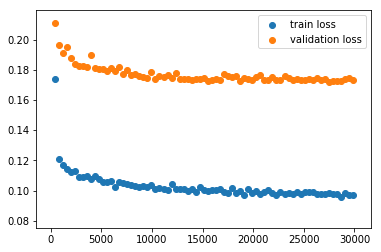

In [44]:
plt.scatter(iterations, train_losses, label='train loss')
plt.scatter(iterations, val_losses, label='validation loss')
plt.legend()
plt.show()

Transform the predicted values back to angles and compare.

In [45]:
validation_preds_angles = [back_to_angle(i.detach().numpy()) for i in validation_preds]

Choose a random protein as test protein

In [46]:
test_protein = val_ids_remain[49]

In [47]:
test_angles_real = val_angles[49]
test_angles_pred = validation_preds_angles[49]

Recover the amino acid sequence. Conveniently the onehot sequence has been filtered with the mask provided by the proteinnet file already, so this sequence will be filtered as well for residues missing atoms. 
<br>
We will make pdb files of the the predicted structure as well as the real structured although the coordinates for the real will be reconstructed from the angles instead of using the actual coordinates, so the comparison is a bit more fair, or something.
<br>
These will be visualized in pymol.

In [48]:
def onehot_to_str(onehot_arr):
    '''aa*N numpy array input'''
    aas = []
    N = onehot_arr.shape[1]
    for i in range(N):
        pos = np.where(onehot_arr[:, i]>0)[0]
        aas.append(pos_aa_dict[int(pos)])
    return "".join(aas)

In [49]:
test_protein_seq = onehot_to_str(val_seqs[49].numpy()[0, :,:])

In [50]:
def make_pb_structure(seq_str, angles):
    psi = np.degrees(angles[0, :].tolist())
    omega = np.degrees(angles[1, :].tolist())
    phi = np.degrees(angles[2, :].tolist())
    structure = PeptideBuilder.make_structure(seq_str, phi, psi, omega)
    return(structure)

In [51]:
test_structure_real = make_pb_structure(test_protein_seq, test_angles_real[0, :, :])

In [52]:
test_structure_pred = make_pb_structure(test_protein_seq, test_angles_pred[0, :, :])

In [53]:
import Bio.PDB
def write_to_pdb(structure, prot_id, identifier):
    out = Bio.PDB.PDBIO()
    out.set_structure(structure)
    out.save(prot_id + identifier + ".pdb")

In [54]:
write_to_pdb(test_structure_real, test_protein, '_real_v8')
write_to_pdb(test_structure_pred, test_protein, '_pred_v8')

We can open the saved pdb files in pymol, align them and save the image. Cyan = true, green = predicted.

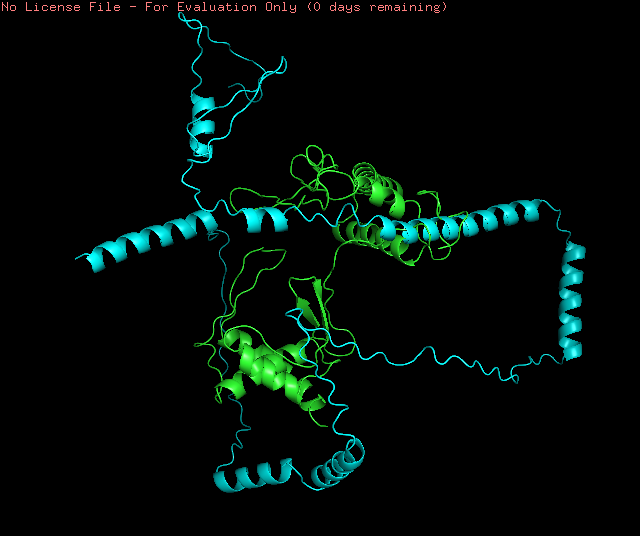

In [55]:
from IPython.display import Image 
im = Image(filename="/Users/Deathvoodoo/big_folders_docs/random/protein_alignment_v8.png")
display(im)

Not quite alphafold tier.
<br>
<br>
Checking distribution of angles for the test protein.

In [56]:
print(test_angles_pred.shape)
print(test_angles_real.shape)

(1, 3, 242)
(1, 3, 242)


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


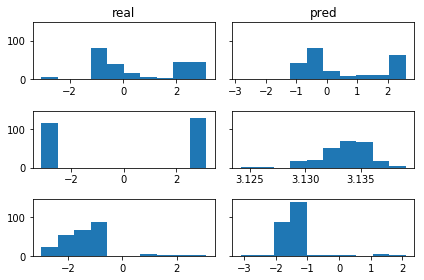

In [57]:
fig, axs = plt.subplots(3, 2, sharey=True, tight_layout=True)
#n_bins=20
labels = ['real', 'pred']
axs[0, 0].hist(test_angles_real[0, 0,:])
axs[0, 0].set_title('real')
axs[0, 1].hist(test_angles_pred[0, 0,:])
axs[0, 1].set_title('pred')
axs[1, 0].hist(test_angles_real[0, 1,:])
axs[1, 1].hist(test_angles_pred[0, 1,:])
axs[2, 0].hist(test_angles_real[0, 2,:])
axs[2, 1].hist(test_angles_pred[0, 2,:])
plt.show()

In [58]:
def make_coord_array(pdbstructure):
    '''turn coordinates into an array to calculate rmsd'''
    structure = pdbstructure
    model = structure[0]
    chain = model['A']

    atom_coords = []
    for atom in chain.get_atoms():
        backbone_atoms = ('N', 'CA', 'C')
        if atom.get_id() in backbone_atoms:
            atom_coords.append(atom.get_coord())
    atom_coords = np.array(atom_coords).T
    return atom_coords
    

In [59]:
test_structure_coords_pred = make_coord_array(test_structure_pred)
test_structure_coords_real = make_coord_array(test_structure_real)

Check RMSD between predicted and 'real' coordinates.

In [60]:
from numpy.linalg import svd, det
def rmsd_calculator(x, y):
    ''' rmsd code from first year of master degree, code might suck. Arrays must be 3*n '''
    n = x.shape[1]
    centered_x = (x.T - np.mean(x, 1)).T # centering the coordinates
    centered_y = (y.T - np.mean(y, 1)).T
    R = centered_y @ centered_x.T
    V, S, WT = svd(R) # singular value decomposition
    U = WT.T@V.T
    Z = np.array([[1,0,0],[0,1,0],[0,0,-1]]) # matrix for reflection catch
    if det(U) < 0: # reflection catch
        U = WT.T @ Z @ V.T
        S[2] = -S[2]
    
    E_0 = np.sum(centered_x**2+centered_y**2)
    rmsd = np.sqrt(1/n*(E_0 - 2*np.sum(S)))
    return(rmsd)


print(rmsd_calculator(test_structure_coords_real, test_structure_coords_pred))

35.73705170232946


Check RMSD between real coordinates and 'real' coordinates reconstructed from angles.

In [61]:
print(rmsd_calculator(val_coords[49], test_structure_coords_real))

1797.2509027557796


Judging by that latter RMSD something is super wrong. We can download the pdb file (1j2p) and inspect things a bit.

In [62]:
print(test_protein)
print(test_structure_coords_real.shape)
print(val_coords[49].shape)

90#1J2P_1_A
(3, 729)
(3, 729)


In [63]:
parser = Bio.PDB.PDBParser(QUIET=True)
test_protein_pdb = parser.get_structure(test_protein, '1j2p.pdb')

In [64]:
test_protein_atomic_coords = make_coord_array(test_protein_pdb) # coordinates from pdb file

In [65]:
val_coords[49][:, 0:10]

array([[4721.5, 4611. , 4661.3, 4766. , 4823.3, 4804.6, 4739.8, 4714.3,
        4848.1, 4845.4],
       [9562.2, 9468.1, 9358. , 9288.2, 9181.9, 9044.4, 8955.6, 8818.9,
        8758.2, 8662.1],
       [-546.8, -575. , -667.4, -624.9, -706.3, -643.7, -719.2, -673.9,
        -634.5, -543.4]])

In [66]:
test_protein_atomic_coords[:, 0:10] # different unit

array([[47.215, 46.11 , 46.613, 47.66 , 48.233, 48.046, 47.398, 47.143,
        48.481, 48.454],
       [95.622, 94.681, 93.58 , 92.882, 91.819, 90.444, 89.556, 88.189,
        87.582, 86.621],
       [-5.468, -5.75 , -6.674, -6.249, -7.063, -6.437, -7.192, -6.739,
        -6.345, -5.434]], dtype=float32)

Looks like the coordinates in the proteinnet file are multiplied with 100 for some reason.

In [67]:
rmsd_calculator(test_protein_atomic_coords, val_coords[49]*0.01) # ok looks better

0.0004235238557565347

Let's check the difference between the protein built from angles and the real one. Note that the full 1j2p structure has 6 chains but since the proteinnet file only uses the A chain we just delete the other ones in pymol.

In [68]:
print(rmsd_calculator(val_coords[49]*0.01, test_structure_coords_real))

14.851347916737454


Cyan = built with peptide builder. Green = real.

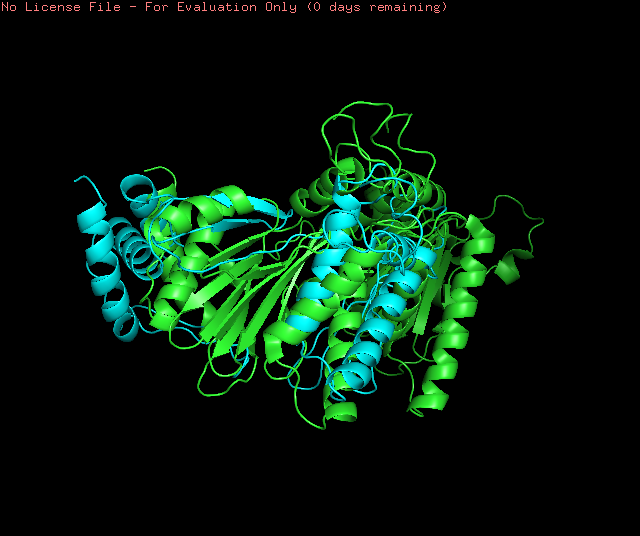

In [69]:
im = Image(filename="/Users/Deathvoodoo/big_folders_docs/random/1j2p_real_fromangles_aligned.png")
display(im)